In [202]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries
using CairoMakie 

In [203]:
Lx = 1000kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))

                       

48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── Bounded  x ∈ [-500000.0, 500000.0] regularly spaced with Δx=20833.3
├── Flat y                             
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=125.0

In [204]:

f = 1e-4
α = 0


# advective forcing term 
u_background = XFaceField(grid)
u_background .= -α * xnodes(grid, Face(), Center(), Center())
background_flow = AdvectiveForcing(u = u_background)

# no addtional u forcing

# v forcing
v_forcing_func(x, z, t, v, α) = - 2*α*v
v_forcing = Forcing(v_forcing_func, parameters = α, field_dependencies = :v )

# w forcing
w_forcing_func(x, z, t, w, α) = - α*w
w_forcing = Forcing(w_forcing_func, parameters = α, field_dependencies = :w )

# b forcing
b_forcing_func(x, z, t, α, b ) = - α*b
b_forcing = Forcing(b_forcing_func, parameters = α, field_dependencies= :b )



model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = background_flow, v = (background_flow, v_forcing) , w = (background_flow, w_forcing), b = (background_flow, b_forcing))
)
                


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO{3, Float64, Float32}(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [205]:
# Initial condition setup (similar to your code but adjusted for frontogenesis)
N² = 1e-6  # [s⁻²] background stratification note: make them both 1e-6
M² = 1e-6  # [s⁻²] horizontal buoyancy gradient (front strength)

Δx = 100kilometers  # initial front width
Δb = Δx * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude

ramp(x, Δx) = min(max(0, x/Δx + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, Δx) + ϵb * randn()

set!(model, b=bᵢ, u = 0, v = 0, w = 0)  # Start from rest


In [206]:
simulation = Simulation(model, Δt=20minutes, stop_time=20days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 20 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => 4
│   ├── stop_iteration_exceeded => -
│   ├── wall_time_limit_exceeded => e
│   └── nan_checker => }
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [207]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [208]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostic/Output

In [209]:
# Output setup
filename = "frontogenesis_2D"
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true 
) 

JLD2Writer scheduled on TimeInterval(12 hours):
├── filepath: frontogenesis_2D.jld2
├── 5 outputs: (b, ζ, u, v, w)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 41.4 KiB

In [210]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 11.090 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info:     ... simulation initialization complete (8.598 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.430 seconds).


[04.76%] i: 100, t: 22.840 hours, wall time: 7.095 seconds, max(u): (3.264e+00, 5.412e+00, 2.287e-02) m/s, next Δt: 15.180 minutes
[09.90%] i: 200, t: 1.980 days, wall time: 901.984 ms, max(u): (2.568e+00, 5.085e+00, 9.753e-03) m/s, next Δt: 17.308 minutes
[16.53%] i: 300, t: 3.306 days, wall time: 848.689 ms, max(u): (1.395e+00, 6.312e+00, 1.687e-02) m/s, next Δt: 20 minutes
[23.47%] i: 400, t: 4.694 days, wall time: 1.014 seconds, max(u): (2.127e+00, 5.307e+00, 1.299e-02) m/s, next Δt: 20 minutes
[30.42%] i: 500, t: 6.083 days, wall time: 958.663 ms, max(u): (1.815e+00, 3.751e+00, 8.168e-03) m/s, next Δt: 20 minutes
[37.36%] i: 600, t: 7.472 days, wall time: 866.899 ms, max(u): (8.753e-01, 2.740e+00, 8.153e-03) m/s, next Δt: 20 minutes
[44.31%] i: 700, t: 8.861 days, wall time: 918.722 ms, max(u): (1.078e+00, 2.689e+00, 6.413e-03) m/s, next Δt: 20 minutes
[51.25%] i: 800, t: 10.250 days, wall time: 967.901 ms, max(u): (1.144e+00, 3.494e+00, 7.171e-03) m/s, next Δt: 20 minutes
[58.19%

[ Info: Simulation is stopping after running for 26.390 seconds.
[ Info: Simulation time 20 days equals or exceeds stop time 20 days.
[ Info: Simulation completed in 26.424 seconds


In [211]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times


0.0:43200.0:1.728e6

In [212]:
# Coordinates
x = xnodes(grid, Center())# ./ 1e2  # km
z = znodes(grid, Center())# ./ 1e2  # km

-937.5:125.0:-62.5

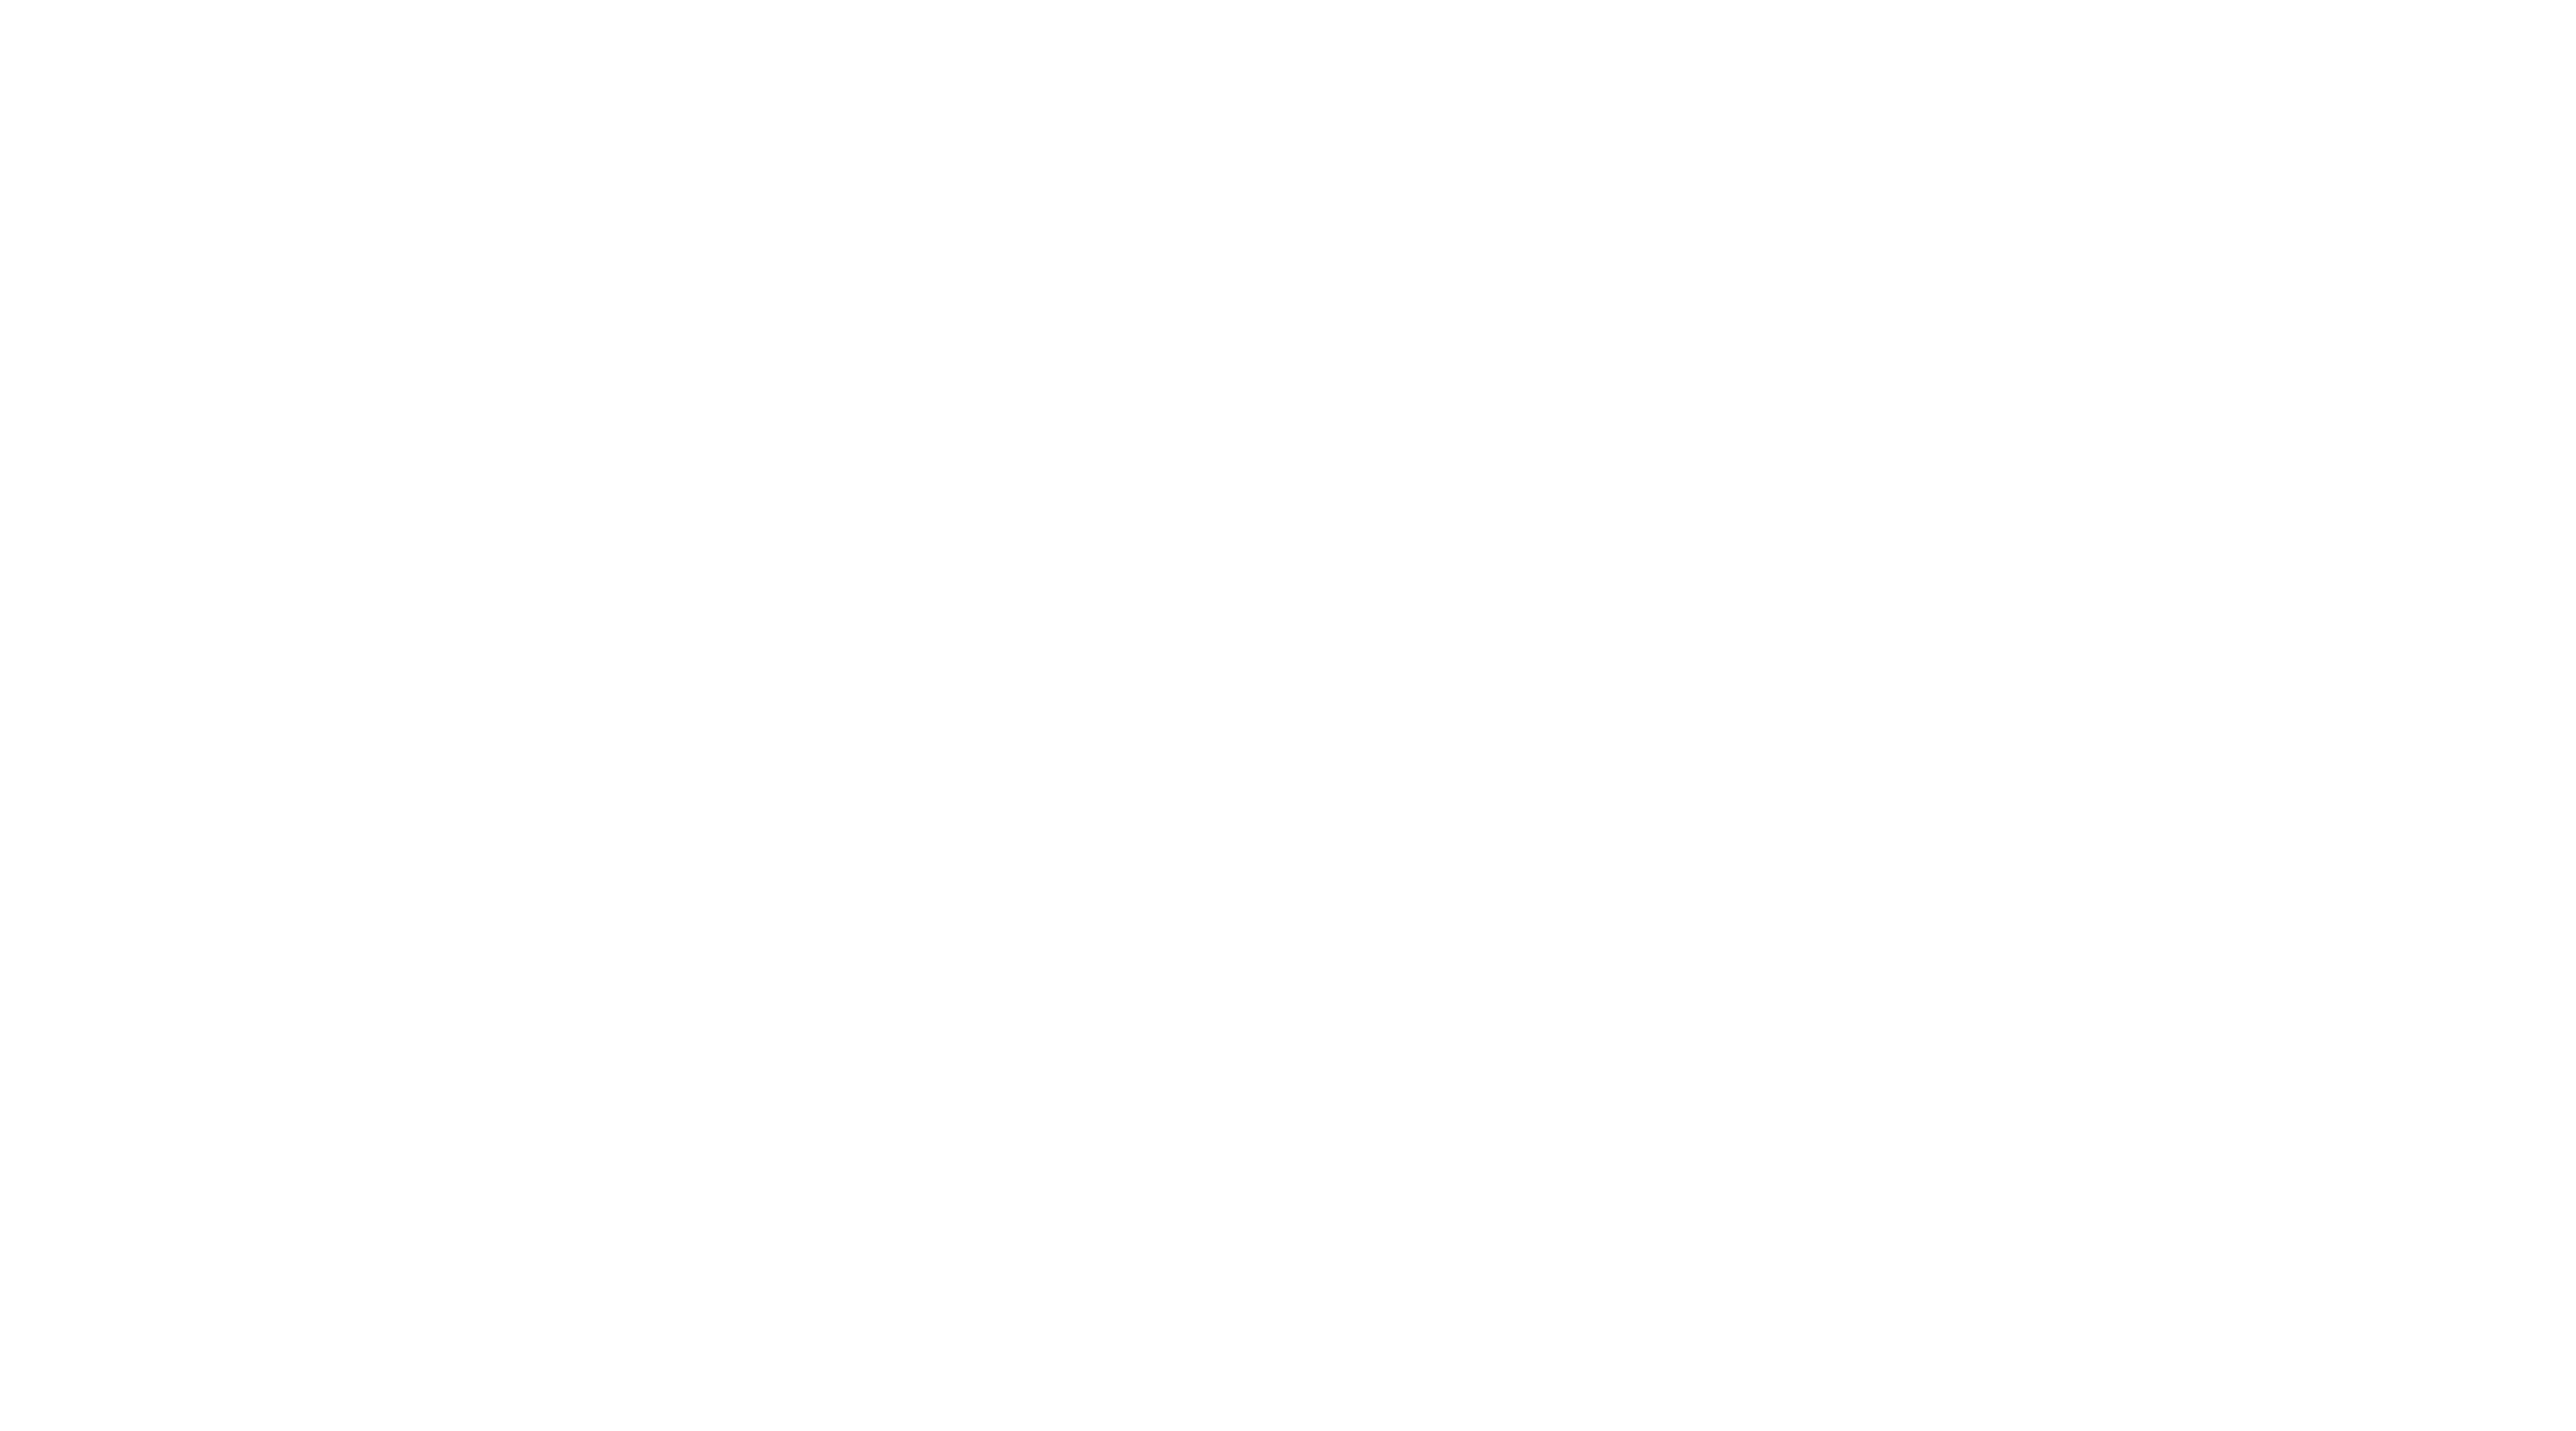

In [213]:
#using CairoMakie
fig = Figure(size=(1800, 1000))

In [214]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], :, 1, :)
ζ_slice = @lift interior(ζ_ts[$n], :, 1, :)

u_slice = @lift interior(u_ts[$n], :, 1, :)
v_slice = @lift interior(v_ts[$n], :, 1, :)
w_slice = @lift interior(w_ts[$n], :, 1, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


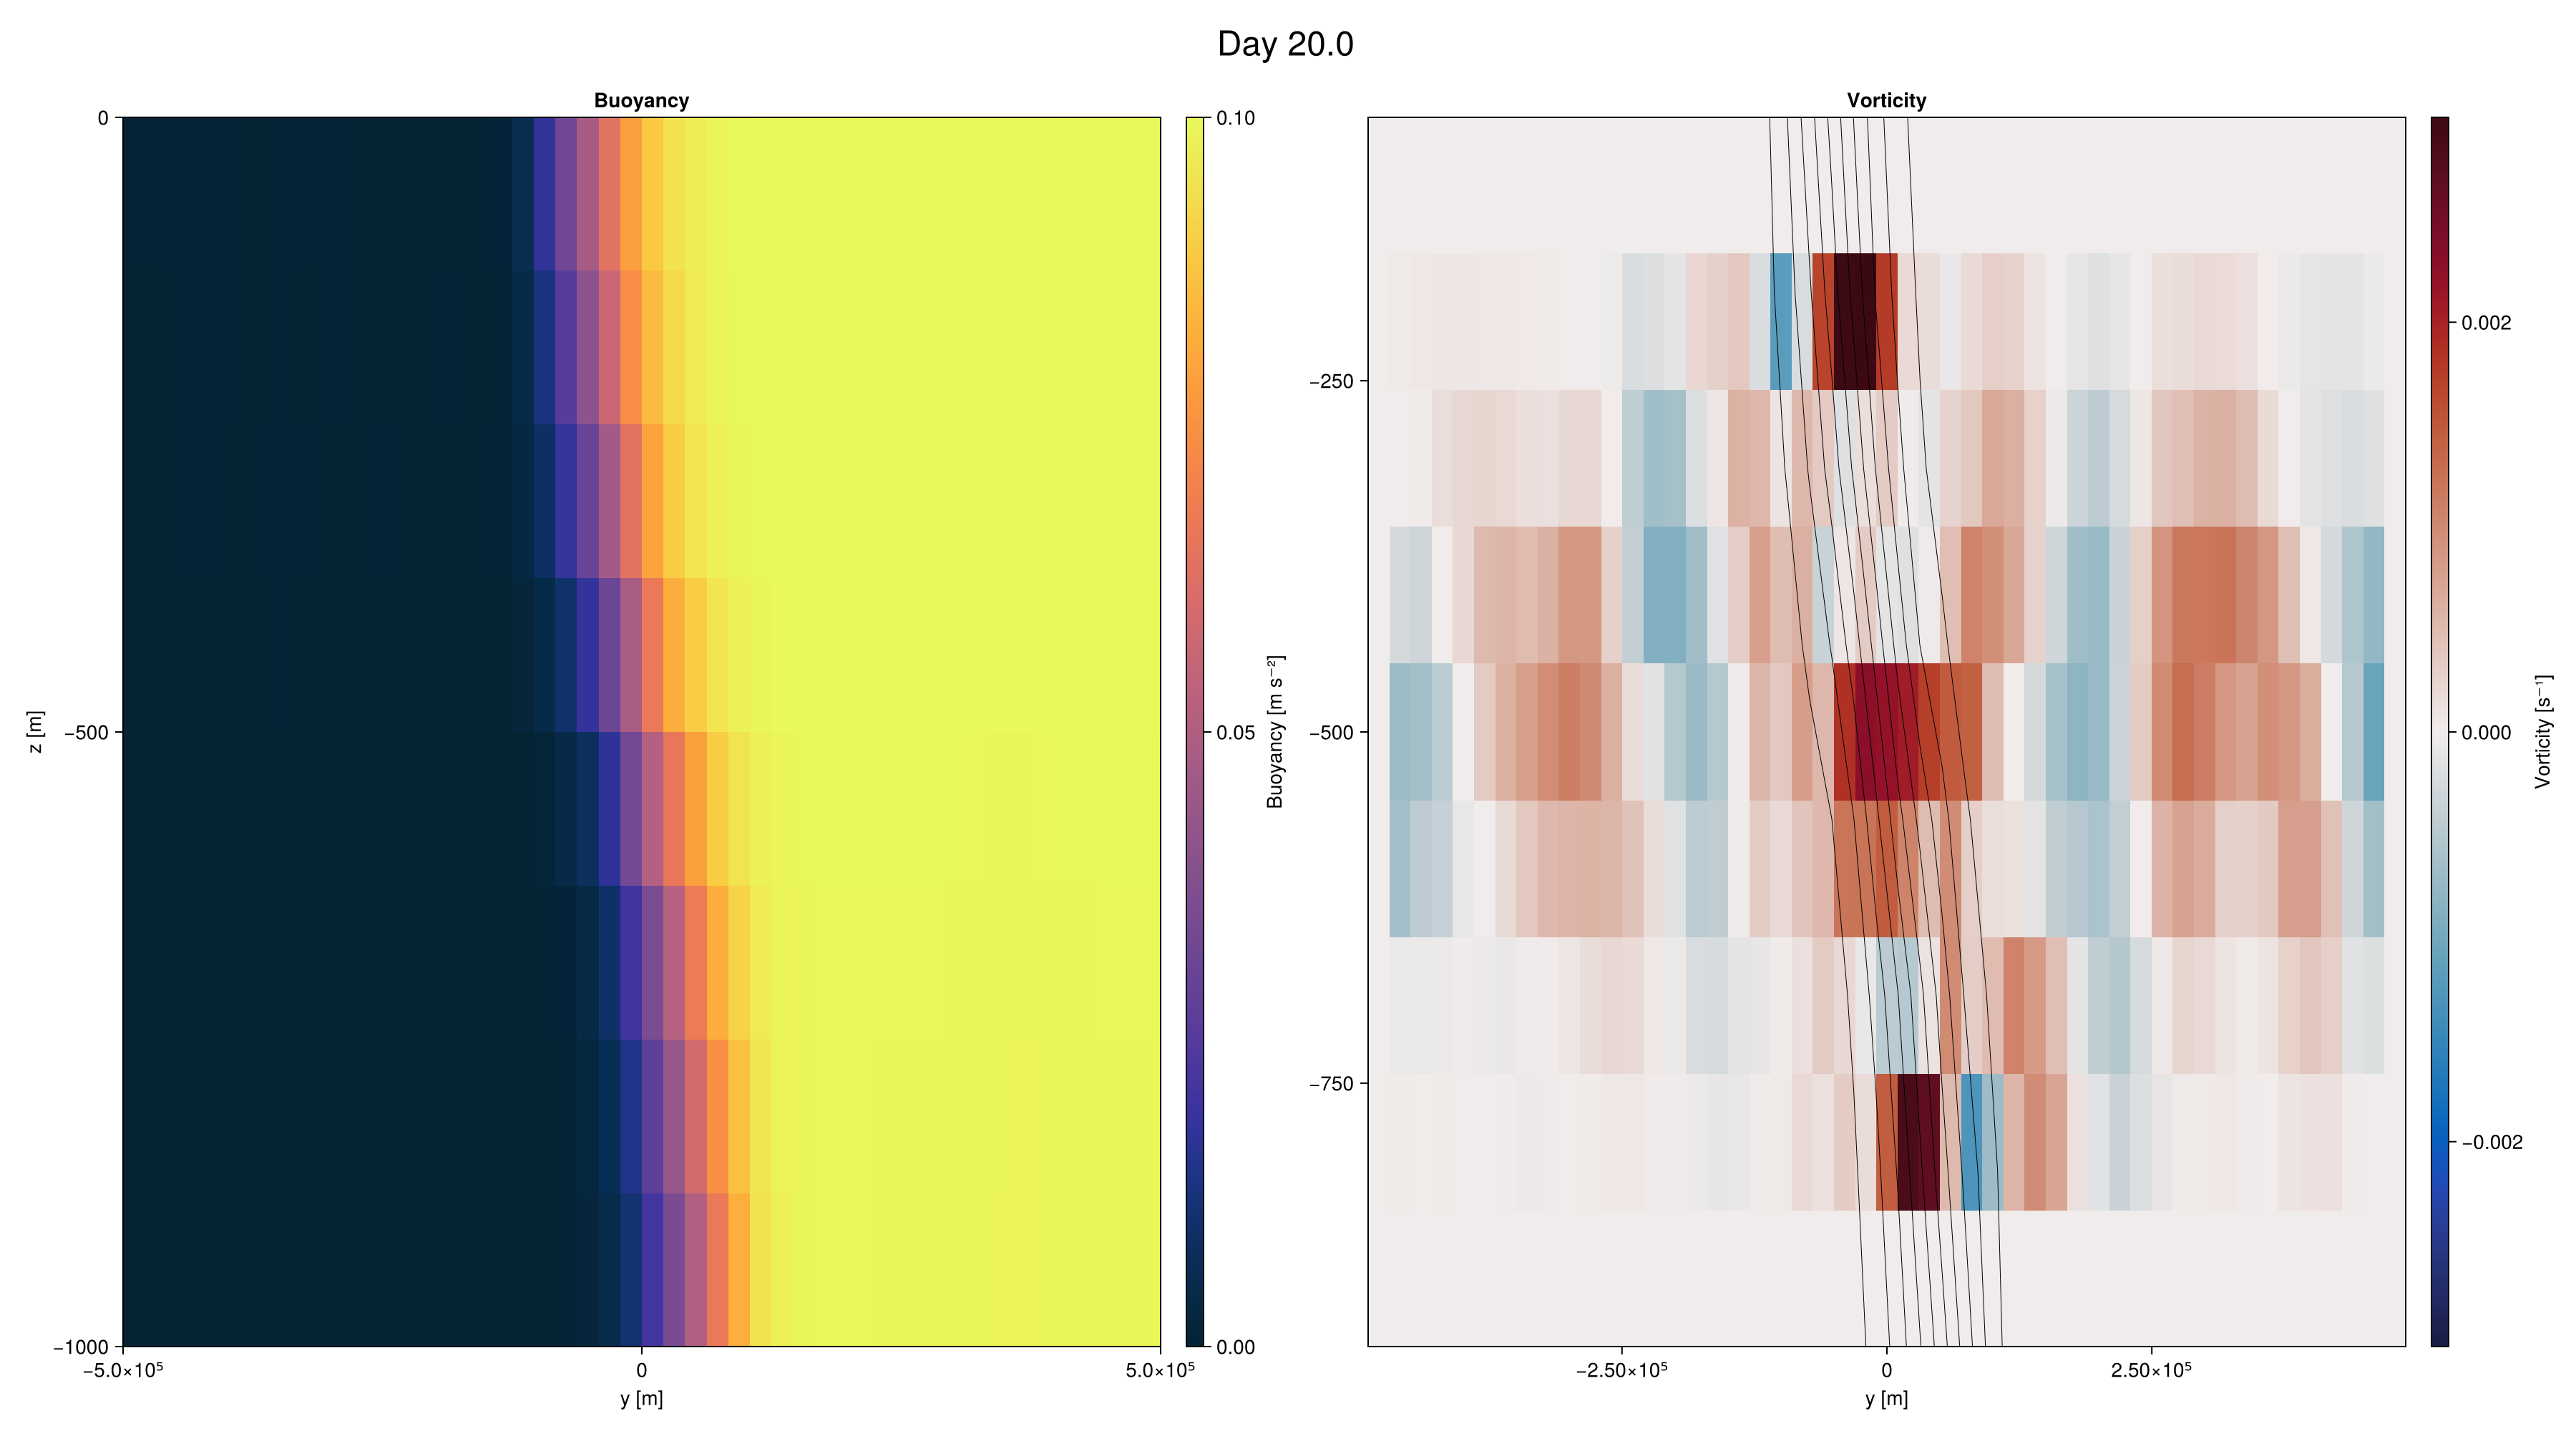

In [220]:


# Animations of Buoyancy and Vorticity
empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, x, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")
#(ax_b, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)


# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, x, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")
contour!(ax_ζ, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 



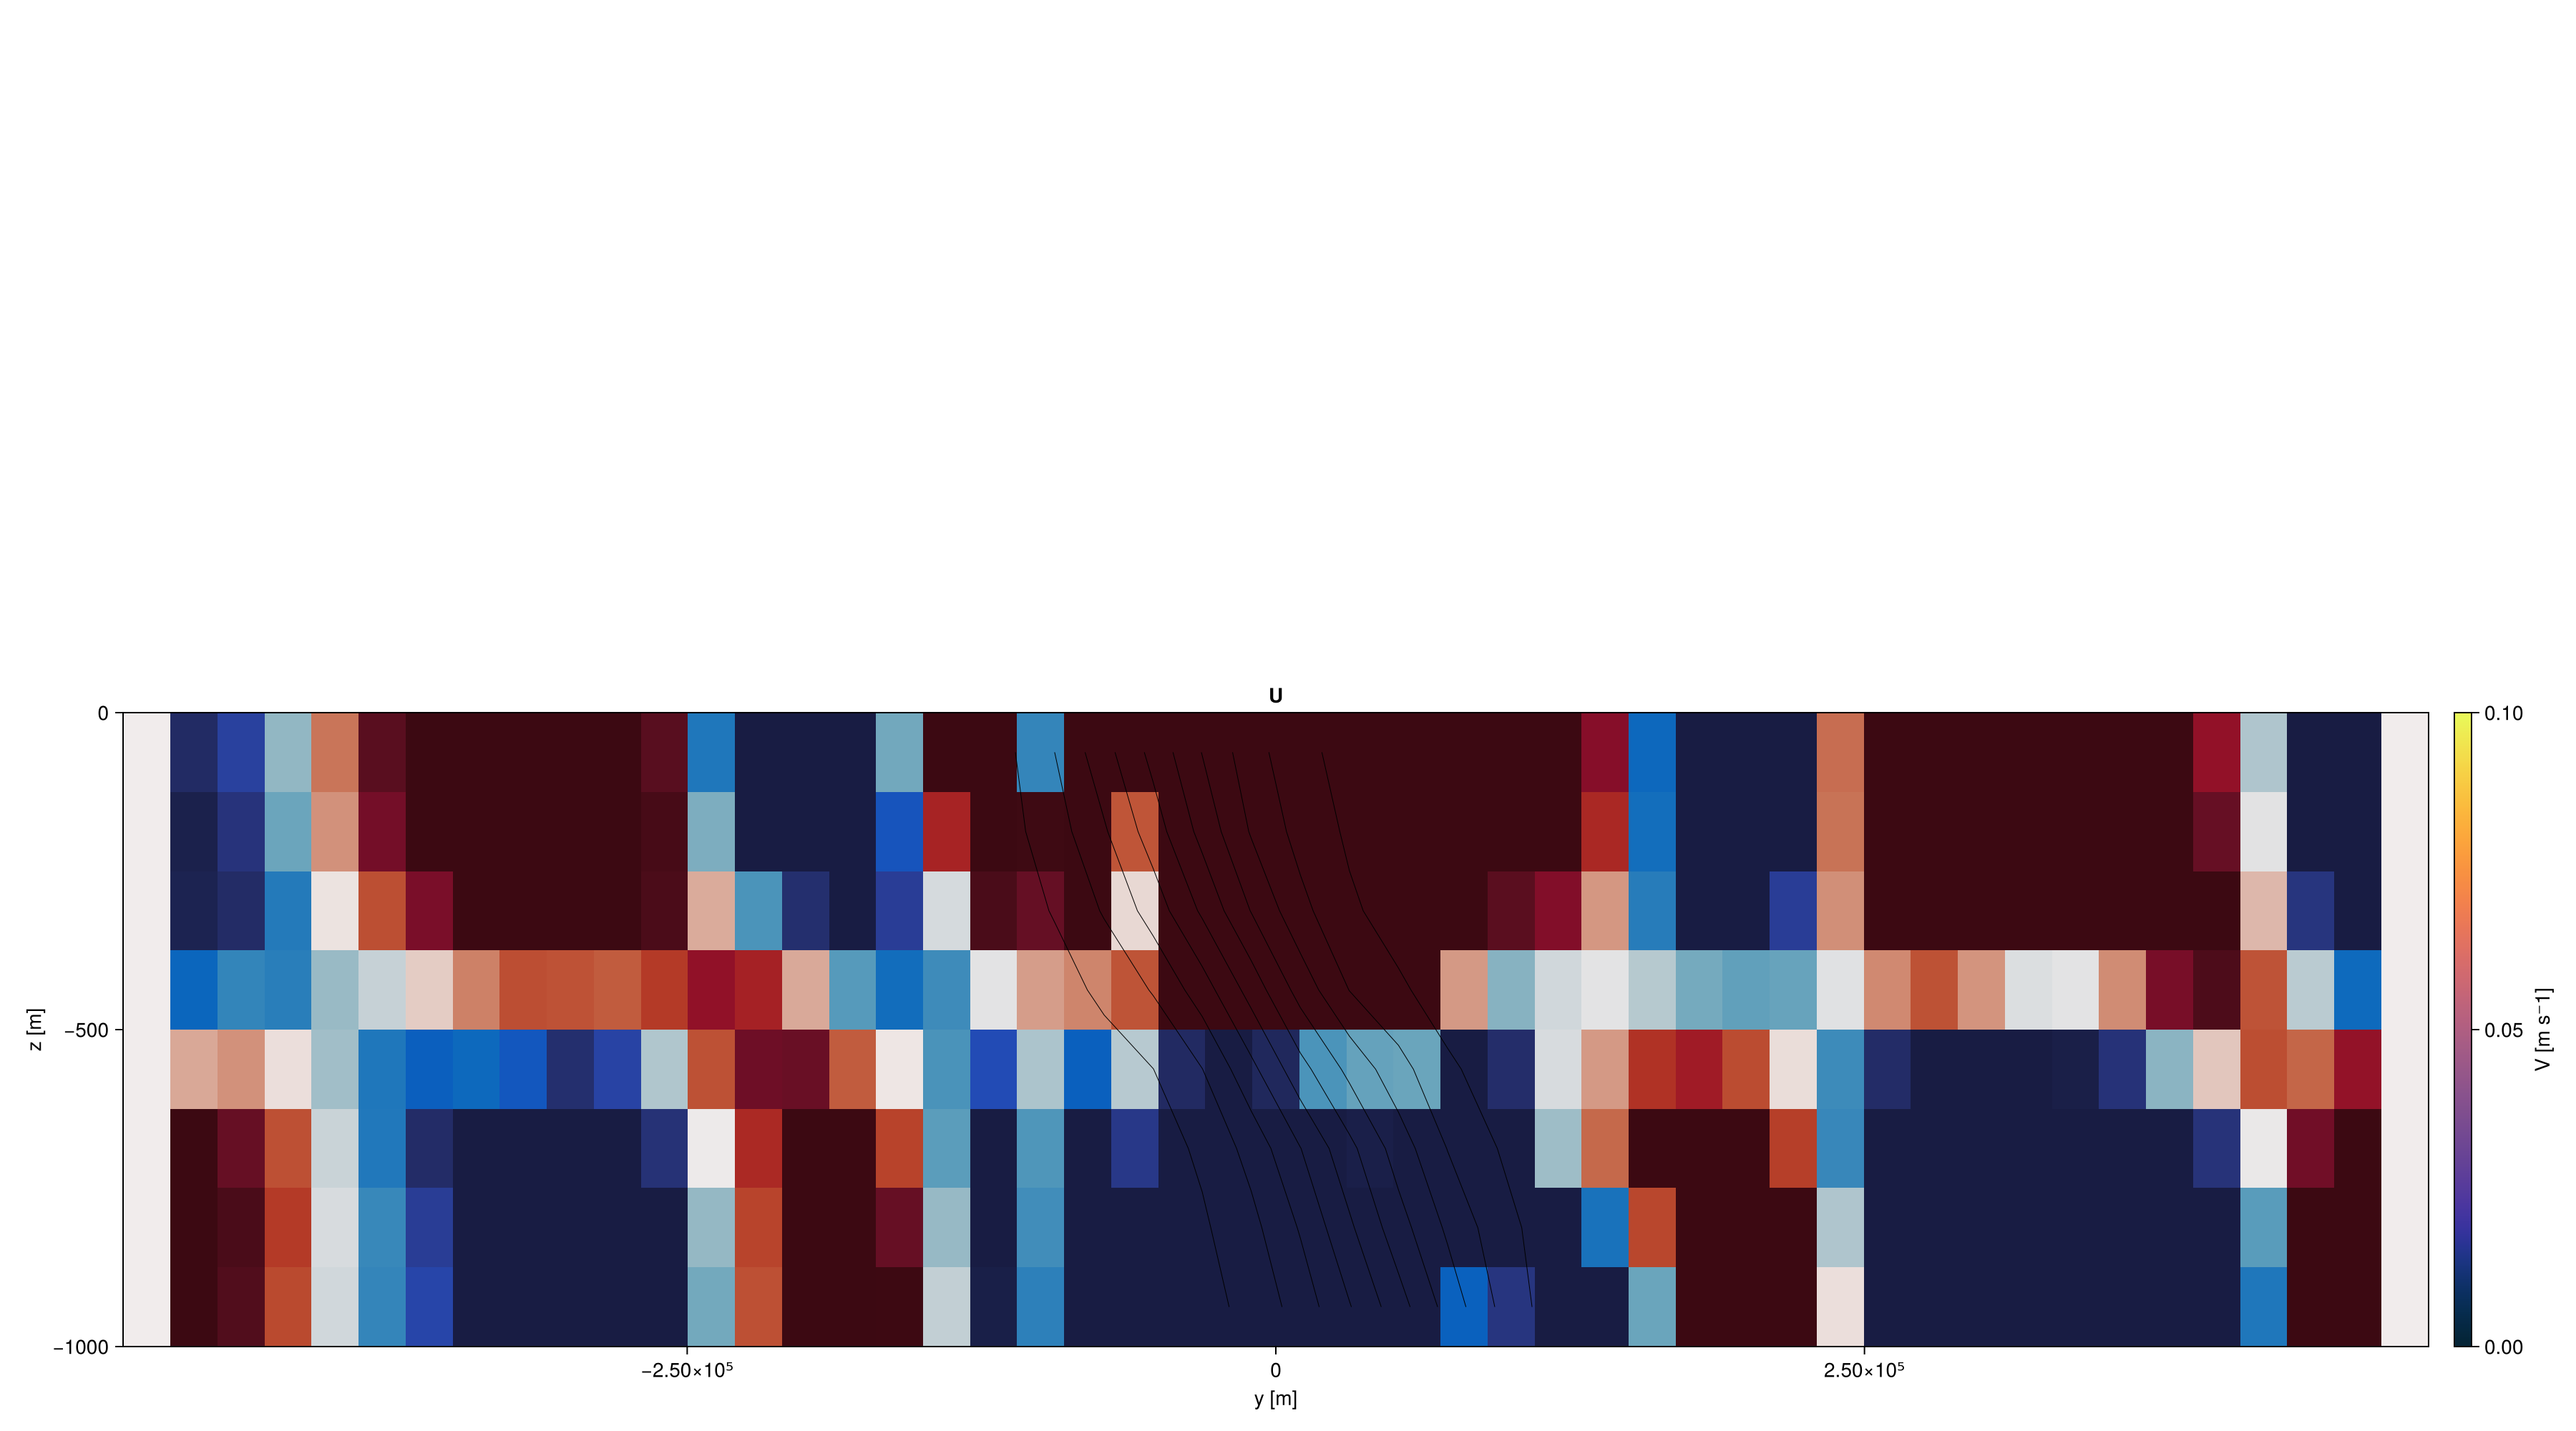

In [219]:
#animation of U only


empty!(fig)

ax_u = Axis(fig[1, 1], title="U", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_u, x, z, u_slice; colorrange=(-1e-1, 1e-1), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

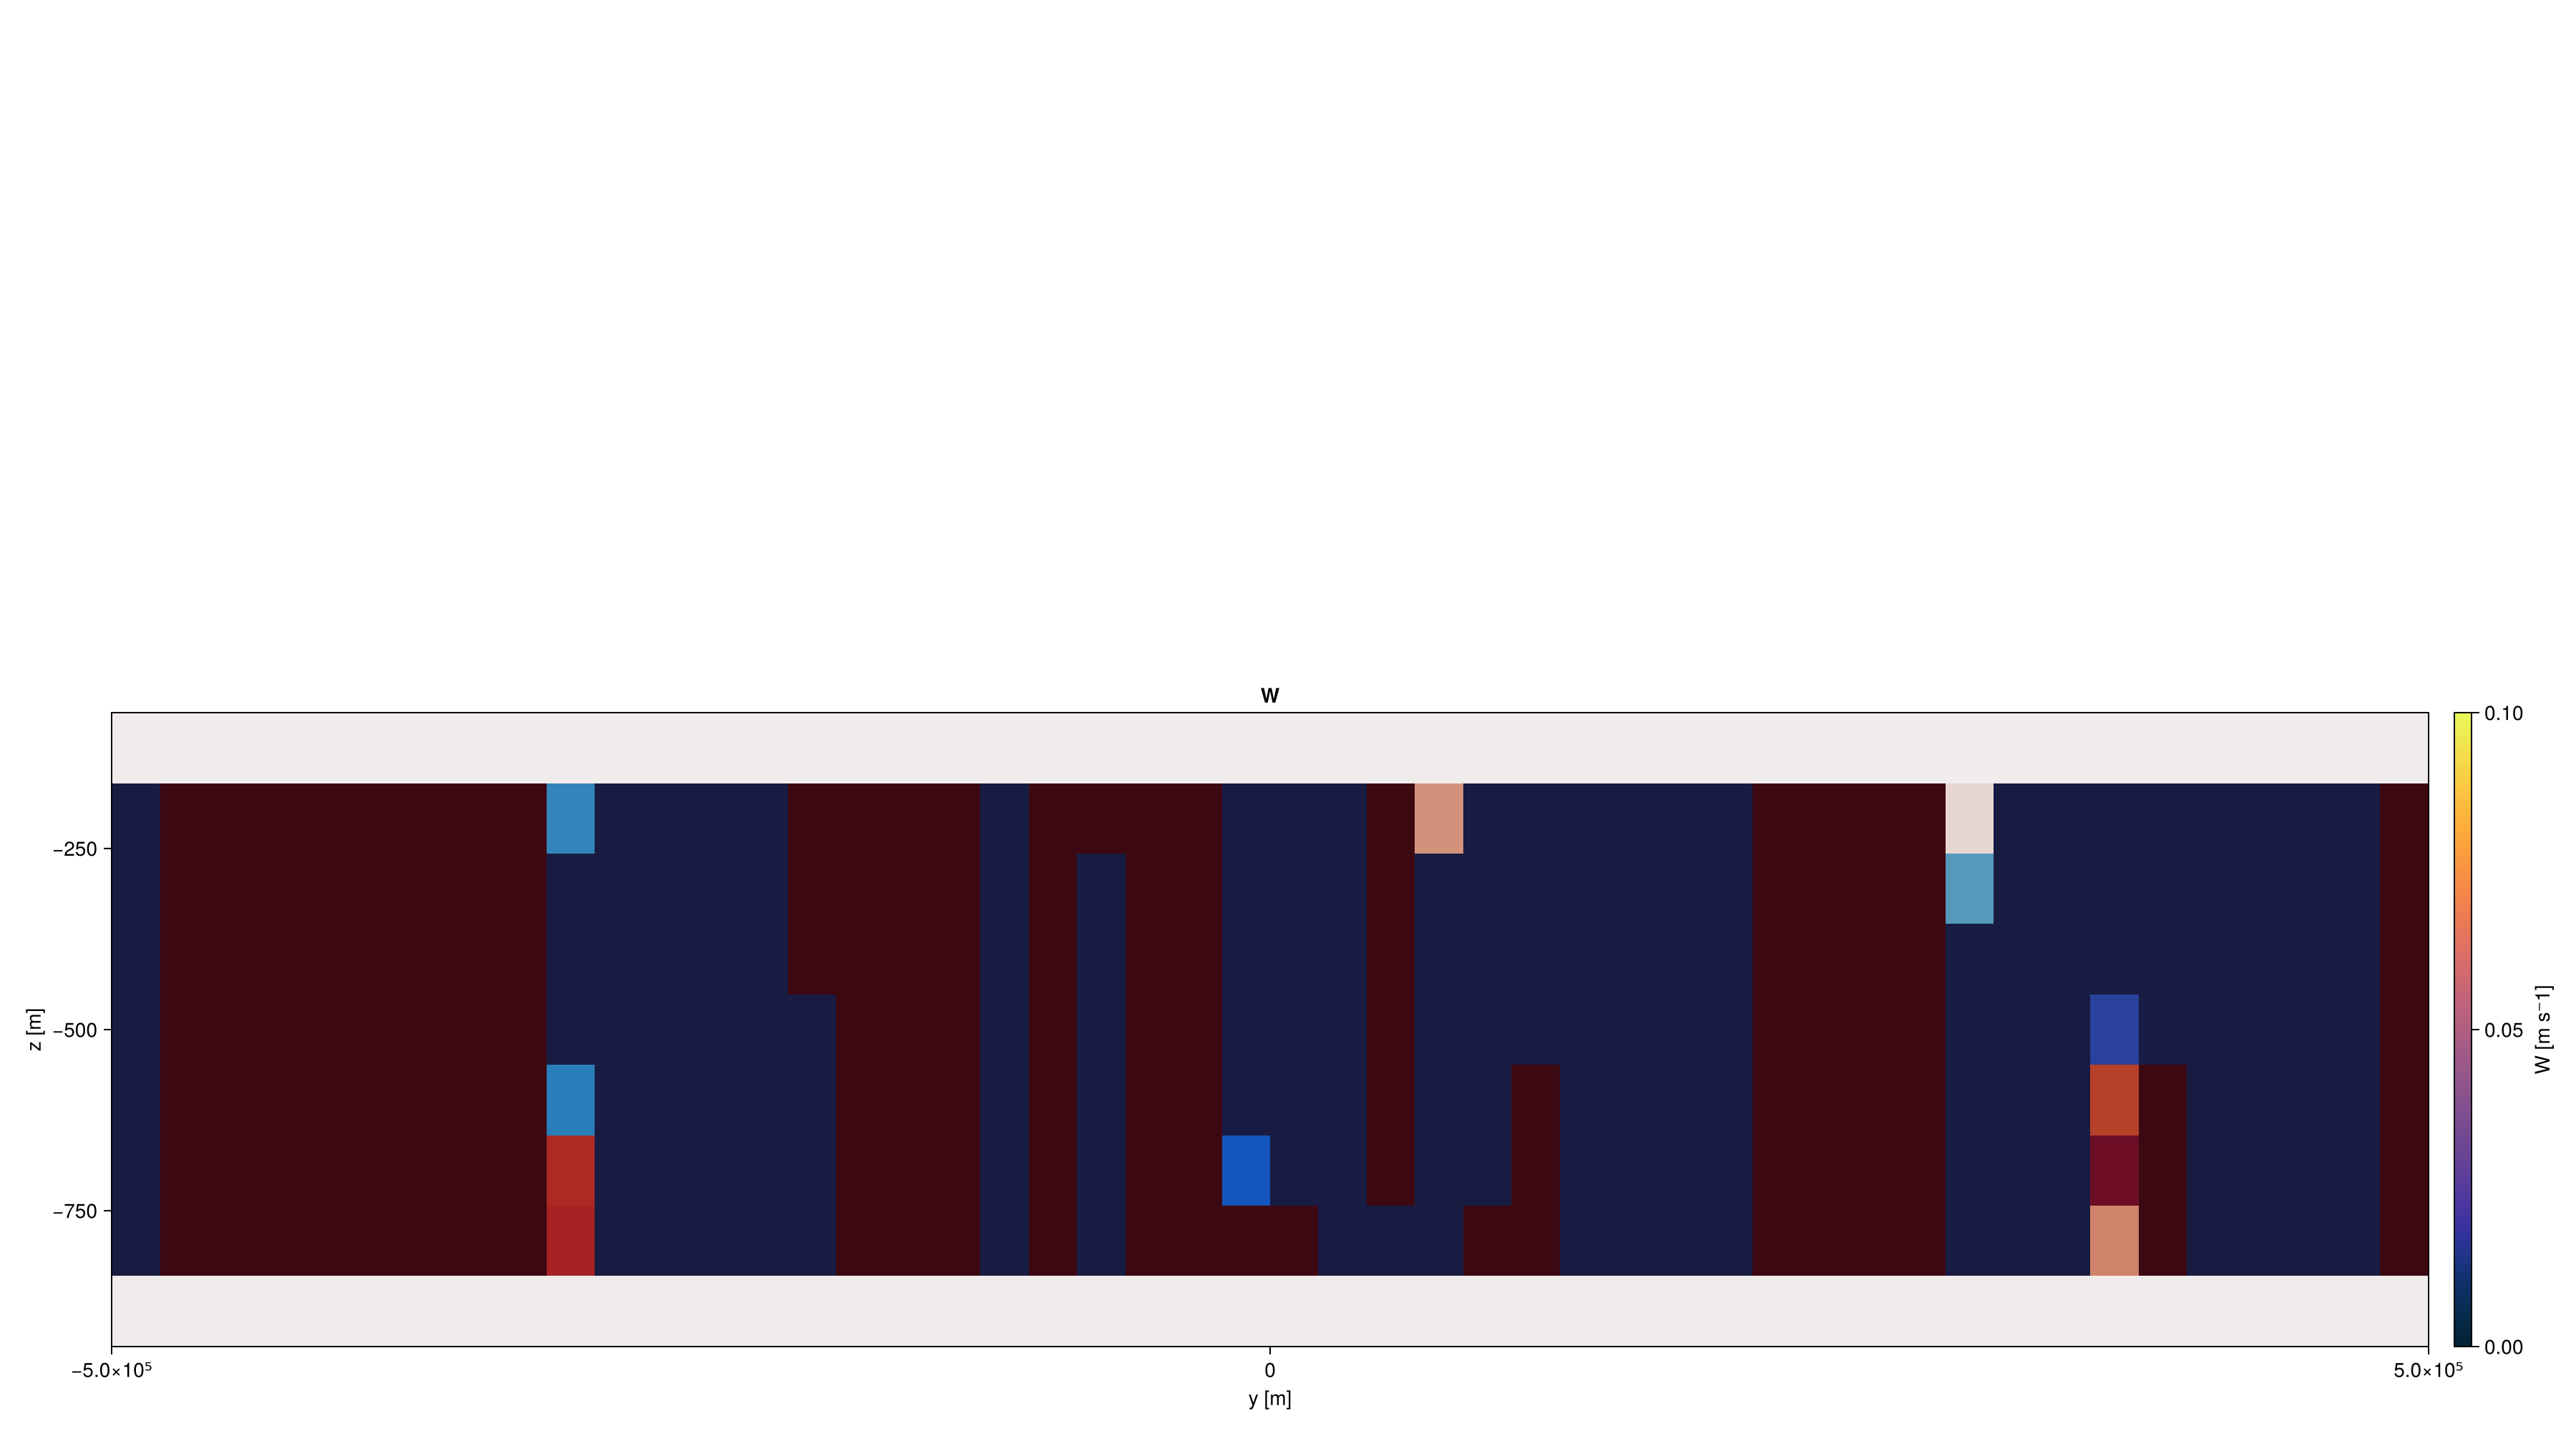

In [217]:
#animation of W only

empty!(fig)

ax_w = Axis(fig[1, 1], title="W", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_w, x, z, w_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="W [m s⁻1]")
#contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame